In [190]:
!pip install pandas-plink limix-lmm


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [191]:
import numpy as np
import pdb
from pandas_plink import read_plink
from limix_lmm import LMM
import pylab as plt
import os
import pandas as pd

In [192]:
import scipy
import scipy.stats as st

if not hasattr(scipy, 'dot'):
    scipy.dot = np.dot
if not hasattr(scipy, 'einsum'):
    scipy.einsum = np.einsum
if not hasattr(scipy, 'log'):
    scipy.log = np.log
if not hasattr(scipy, 'sign'):
    scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'):
    scipy.sqrt = np.sqrt

In [193]:
!wget -O ALL.chr22_GRCh38.genotypes.20170504.zip "https://www.dropbox.com/s/86fdj3i7ir3vap7/ALL.chr22_GRCh38.genotypes.20170504.zip?dl=1"
!unzip -o -q ALL.chr22_GRCh38.genotypes.20170504.zip && rm ALL.chr22_GRCh38.genotypes.20170504.zip

--2026-02-13 12:44:09--  https://www.dropbox.com/s/86fdj3i7ir3vap7/ALL.chr22_GRCh38.genotypes.20170504.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6022:18::a27d:4212, 162.125.66.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6022:18::a27d:4212|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&dl=1 [following]
--2026-02-13 12:44:10--  https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&dl=1
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd57485238ddd4a37ad81e59329.dl.dropboxusercontent.com/cd/0/inline/C63pggExNsIC4Cm1P7Zl9-gMFEeK7CtO32eX7av9t8cZ5ZpkNs7sqmR_wN6dRbr52XzFgqULYHMy91fEKKKjUGGjpSO1t3N0oKv1I_BYq3Ism6vXxws1QuiTbGV1l2kMekU/file?dl=1# [following]
--

In [194]:
# load genetic data
bfile = 'ALL.chr22_GRCh38.genotypes.20170504'
bim, fam, G = read_plink(bfile)

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Preprocessing

In [195]:
print(G.shape)   # (n_variants, n_samples)
print(bim.head())
print(fam.head())
print(G.shape[0], bim.shape[0], fam.shape[0])


(109827, 2504)
  chrom          snp   cm       pos a0 a1  i
0    22    rs9617549  0.0  10874444  T  C  0
1    22    rs5747224  0.0  11122151  A  G  1
2    22    rs2456393  0.0  11122417  T  G  2
3    22  rs199668908  0.0  11123683  C  T  3
4    22    rs4010319  0.0  11123736  C  T  4
       fid      iid father mother gender trait  i
0  HG00096  HG00096      0      0      0    -9  0
1  HG00097  HG00097      0      0      0    -9  1
2  HG00099  HG00099      0      0      0    -9  2
3  HG00100  HG00100      0      0      0    -9  3
4  HG00101  HG00101      0      0      0    -9  4
109827 109827 2504


In [197]:
#remove variants with many missing data
G = G.compute()
snp_missing = np.mean(np.isnan(G), axis=1)
keep_missing = snp_missing < 0.01
G = G[keep_missing, :]
bim = bim.iloc[keep_missing].copy()
bim.reset_index(drop=True, inplace=True)
bim['i'] = np.arange(len(bim))

In [198]:
print(G.shape) 

(109803, 2504)


In [199]:
#removing duplicates of variants to avoid bias
duplicate = bim.duplicated(subset=['chrom', 'pos'], keep='first')
G = G[~duplicate, :]
bim = bim.loc[~duplicate].copy()
bim.reset_index(drop=True, inplace=True)
bim['i'] = np.arange(len(bim))


In [200]:
print(G.shape) 

(109712, 2504)


In [201]:
#retaining only common variants -MAF >=1% or 5%
allele_freq = np.nanmean(G, axis=1) / 2
maf = np.minimum(allele_freq, 1 - allele_freq)
keep_maf = maf > 0.05
G = G[keep_maf, :]
bim = bim.iloc[keep_maf].copy()
bim.reset_index(drop=True, inplace=True)
bim['i'] = np.arange(len(bim)) 

In [202]:
print(G.shape) 

(109712, 2504)


In [203]:
def extract_region(bim, G, chrom, start, end):
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values]
    bim['i'] = np.arange(len(bim))
    return bim, G

In [204]:
def subset_individuals(fam, G, keep_idxs):
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return bim, G

In [205]:
# subset to 1000 individuals
N = 1000
np.random.seed(0)
idxs = np.sort(np.random.permutation(fam.shape[0])[:N])
fams, Gs = subset_individuals(fam, G, idxs)

In [206]:
# extract region
chrom = 22
start = 30797531
size = 100000
bimr, Gr = extract_region(bim, Gs, chrom, start, start + size)

In [207]:
# load genotype matrix
X = Gr.T

Phase 1: Phenotype Simulation

In [208]:
def simulate_pheno(X, idx_caus, var_expl, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (np.random.rand(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * np.random.randn(X.shape[0], 1)

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [209]:
def qq_plot(p_values, figsize, title): #parameters changed
    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    if figsize is not None: #added
      plt.figure(figsize=figsize) #added
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')
    plt.title(title)

In [210]:
# Generate phenotype
#n_causal = 10 # number of causal variants
#idx_caus = np.random.choice(X.shape[1], size=n_causal)
#var_expl = np.repeat(0.06, n_causal)

h2_values = [0.1,0.6]
n_causal_values = [10, 100]

for h2 in h2_values:
    for n_causal in n_causal_values:
        idx_caus = np.random.choice(X.shape[1], size=n_causal) 
        var_expl = np.full(n_causal, h2 / n_causal)
        y, beta_real = simulate_pheno(X, idx_caus, var_expl)

In [211]:
# Perform genetic association testing
F = np.ones_like(y)
lmm = LMM(y, F)
lmm.process(X)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

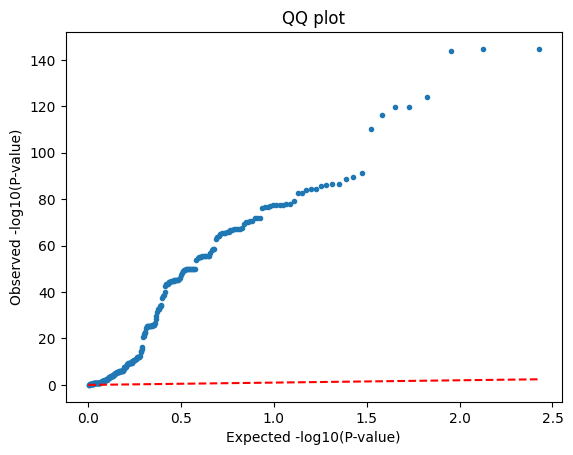

<Figure size 640x480 with 0 Axes>

In [214]:
# TODO: Create and show QQ plot
qq_plot(pv, None, 'QQ plot')
plt.show()
plt.savefig('qq.png')

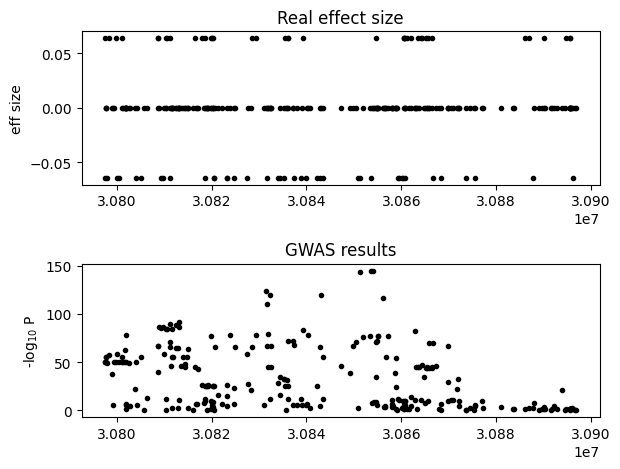

<Figure size 640x480 with 0 Axes>

In [215]:
# Plot ground truth and results
x = bimr['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log$_{10}$ P')
plt.tight_layout()
plt.show()
plt.savefig('gwas_results.png')